In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/yolo/cheque dz

/content/drive/MyDrive/yolo/cheque dz


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 35.7 MB/s eta 0:00:00


In [5]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
import torch
print(torch.cuda.is_available())  # Should return True

True


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
!ls

data.yaml  train  valid


In [ ]:
model = YOLO('yolov8n.pt')
model = model.to(device)  # Assuming 'model' is your YOLO model
results = model.train(
        data=r'/content/drive/MyDrive/yolo/cheque dz/data.yaml',
        imgsz=800,
        epochs=400,
        batch=16,
        close_mosaic=0,
        name='first')

engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/yolo/cheque dz/data.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=first4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, o

train: Scanning /content/drive/MyDrive/yolo/cheque dz/train/labels.cache... 282 images, 0 backgrounds, 0 corrupt: 100%|██████████| 282/282 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/yolo/cheque dz/valid/labels.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]


Plotting labels to runs/detect/first4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/first4
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      6.26G      2.389      4.229      2.024         51        800: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         54        131    0.00591      0.651       0.15     0.0705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400       6.3G      1.583      2.954       1.35         50        800: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         54        131    0.00413      0.426      0.203     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      6.29G      1.443      2.148      1.256         51        800: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         54        131    0.00291      0.253      0.122      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400       6.3G      1.352      1.751      1.177         62        800: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         54        131    0.00433      0.538      0.279      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      6.29G      1.314      1.577      1.154         57        800: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         54        131    0.00716      0.766      0.516      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      6.29G      1.274      1.428      1.117         49        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         54        131      0.977      0.106      0.733      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400       6.3G      1.236      1.323      1.109         51        800: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         54        131      0.895      0.397      0.709      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400       6.3G      1.186      1.227      1.085         39        800: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         54        131       0.77      0.707      0.839      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      6.29G      1.171      1.184      1.076         51        800: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         54        131      0.747       0.82      0.908       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      6.29G      1.173      1.107      1.069         57        800: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         54        131      0.898      0.888      0.953      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400       6.3G      1.152      1.068      1.057         49        800: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         54        131      0.882      0.956      0.932      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400       6.3G      1.231      1.052      1.085         55        800: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.853      0.905      0.929      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400       6.3G      1.161      1.008      1.079         59        800: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         54        131      0.829      0.904      0.922      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400       6.3G      1.099     0.9481      1.043         69        800: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         54        131      0.881      0.946      0.951      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      6.29G      1.084     0.9121      1.044         49        800: 100%|██████████| 18/18 [00:12<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         54        131      0.912       0.98      0.977       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400       6.3G      1.084     0.8636       1.03         50        800: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         54        131      0.963      0.938      0.983      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400       6.3G      1.096     0.8776      1.048         57        800: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         54        131      0.913       0.91      0.965      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400       6.3G      1.067     0.8393       1.03         50        800: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         54        131      0.928      0.924      0.971      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400       6.3G      1.113     0.8539      1.046         49        800: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         54        131      0.836      0.953      0.949      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      6.29G      1.039     0.8023      1.027         46        800: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         54        131      0.934      0.892      0.952      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      6.29G      1.027     0.7704      1.008         45        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.911      0.943      0.965       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400       6.3G       1.04     0.7492      1.006         59        800: 100%|██████████| 18/18 [00:11<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         54        131       0.91      0.965      0.959      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      6.29G      1.005      0.738       1.01         51        800: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         54        131      0.916      0.962      0.972      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      6.29G     0.9735     0.6982     0.9954         42        800: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         54        131      0.966       0.87       0.95      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      6.29G      1.013     0.7124      1.007         62        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         54        131       0.96      0.949      0.982      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400       6.3G     0.9998     0.7119      1.002         58        800: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         54        131      0.938      0.978      0.985      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400       6.3G     0.9916     0.6914     0.9944         45        800: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         54        131      0.953      0.956      0.989      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400       6.3G      1.015     0.6985      1.002         44        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         54        131      0.945      0.954      0.988      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      6.29G     0.9658      0.668     0.9932         39        800: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         54        131      0.976      0.945      0.984      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400       6.3G     0.9975     0.6812          1         48        800: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         54        131      0.933      0.935      0.971      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      6.31G      1.037     0.7045      1.006         52        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         54        131      0.934      0.945      0.985      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400       6.3G     0.9985     0.6895      1.008         53        800: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         54        131      0.961      0.915      0.979      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400       6.3G      1.006     0.6695      0.992         53        800: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         54        131      0.915      0.979      0.981       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      6.29G     0.9714     0.6458     0.9954         62        800: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         54        131      0.936      0.965      0.984      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400       6.3G     0.9273     0.6201      0.978         52        800: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         54        131      0.959       0.97      0.986        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400       6.3G     0.9289     0.6205     0.9749         56        800: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.952      0.965      0.988      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      6.29G     0.9292      0.628     0.9774         50        800: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         54        131      0.959      0.976      0.992      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400       6.3G     0.9513     0.6323     0.9806         55        800: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         54        131      0.929      0.977      0.958      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400       6.3G     0.9282      0.611     0.9767         53        800: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         54        131      0.919      0.957      0.983      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      6.29G     0.9633      0.606     0.9842         51        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         54        131      0.936      0.981      0.986      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400       6.3G     0.9334     0.6043     0.9747         54        800: 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         54        131      0.939      0.946      0.979      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400       6.3G     0.9126     0.5961     0.9805         55        800: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         54        131      0.972      0.977      0.992      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      6.29G     0.8946     0.5826     0.9615         59        800: 100%|██████████| 18/18 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         54        131      0.951      0.951      0.988       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400       6.3G     0.9243     0.5914     0.9736         35        800: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         54        131      0.954      0.956      0.975      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      6.29G     0.9075     0.5883     0.9597         56        800: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.979      0.967       0.99      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400       6.3G     0.9352     0.5925     0.9775         52        800: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         54        131      0.958      0.941      0.981      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400       6.3G     0.9878     0.6072     0.9814         58        800: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         54        131      0.943      0.981      0.976      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400       6.3G     0.9163     0.5847      0.973         56        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         54        131      0.961      0.979      0.992       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400       6.3G     0.8869     0.5591     0.9538         51        800: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         54        131      0.959      0.986      0.985      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      6.29G     0.8483     0.5452     0.9627         46        800: 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         54        131      0.906      0.913      0.938      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400       6.3G     0.8574     0.5611     0.9558         49        800: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         54        131       0.98      0.952      0.986      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400       6.3G     0.8734     0.5643     0.9667         50        800: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         54        131      0.951      0.979      0.986      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      6.29G     0.8736     0.5444     0.9618         56        800: 100%|██████████| 18/18 [00:08<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         54        131      0.929      0.949      0.977      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      6.31G     0.8606      0.538     0.9639         51        800: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         54        131      0.931      0.991      0.988      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      6.29G     0.8575     0.5372     0.9597         40        800: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         54        131      0.966      0.975      0.989      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400       6.3G     0.8933      0.549     0.9649         48        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         54        131      0.883      0.955       0.95      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      6.29G     0.9041     0.5572     0.9615         51        800: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         54        131      0.974      0.963      0.986      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      6.29G      0.875      0.524     0.9603         46        800: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         54        131      0.959       0.98      0.986      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      6.29G     0.8536     0.5272      0.963         50        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         54        131      0.951      0.994      0.978      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      6.29G      0.844     0.5081     0.9433         50        800: 100%|██████████| 18/18 [00:12<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         54        131      0.956      0.988      0.989      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      6.29G     0.8247     0.5266     0.9424         64        800: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         54        131      0.898      0.976      0.973      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400       6.3G     0.7964     0.4978     0.9302         45        800: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         54        131       0.92      0.994      0.972      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400       6.3G     0.8117     0.5103     0.9507         53        800: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         54        131      0.935      0.993      0.976      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400       6.3G     0.8464     0.5225      0.952         65        800: 100%|██████████| 18/18 [00:11<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         54        131      0.954      0.984      0.984      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400       6.3G     0.8306     0.5166      0.935         55        800: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         54        131       0.96      0.979      0.987        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      6.29G     0.8228     0.5282     0.9509         53        800: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         54        131      0.984      0.984      0.994      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      6.29G     0.8294     0.5174     0.9434         55        800: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         54        131      0.992      0.979      0.994      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400       6.3G     0.8186      0.504     0.9344         60        800: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         54        131      0.972      0.994      0.994      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400       6.3G     0.8265     0.5095     0.9395         54        800: 100%|██████████| 18/18 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         54        131       0.96      0.988      0.988      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      6.29G     0.8248     0.5079      0.938         55        800: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         54        131      0.959      0.988      0.986      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      6.29G     0.8024      0.498     0.9344         62        800: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         54        131      0.962      0.984      0.987      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400       6.3G     0.7582     0.4812     0.9335         55        800: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         54        131      0.971       0.99      0.993      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400       6.3G     0.7909     0.4897     0.9366         43        800: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         54        131      0.979      0.993      0.993      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      6.29G     0.8084     0.4904     0.9335         54        800: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         54        131      0.961      0.994      0.984      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400       6.3G     0.7785     0.4819      0.931         38        800: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         54        131      0.965      0.966      0.988      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400       6.3G     0.7824     0.4827      0.938         57        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         54        131      0.983          1      0.995      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      6.29G     0.7829     0.4741     0.9342         58        800: 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         54        131       0.97       0.98      0.991       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400       6.3G     0.8095     0.4816     0.9349         45        800: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         54        131      0.979          1      0.995      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400       6.3G     0.7896     0.4719     0.9261         49        800: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         54        131      0.973      0.994      0.989      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400       6.3G     0.8177     0.4804     0.9347         58        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         54        131      0.978      0.994      0.992      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400       6.3G     0.7913     0.4868     0.9349         56        800: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         54        131      0.979      0.994      0.992      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400       6.3G     0.7734     0.4722     0.9326         44        800: 100%|██████████| 18/18 [00:12<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         54        131      0.985      0.993      0.994      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400       6.3G     0.7682     0.4667     0.9288         55        800: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         54        131      0.978      0.993      0.989      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400       6.3G     0.7488     0.4617     0.9198         55        800: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         54        131      0.984      0.979      0.991      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      6.29G     0.7524     0.4647     0.9209         57        800: 100%|██████████| 18/18 [00:12<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         54        131      0.994      0.983      0.994      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      6.27G     0.7627     0.4786     0.9187         51        800: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         54        131      0.985      0.988      0.987      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400       6.3G     0.7443     0.4687     0.9178         35        800: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         54        131      0.981      0.979      0.987      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400       6.3G     0.7666     0.4791     0.9341         59        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         54        131       0.99      0.998      0.994      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      6.29G     0.7499     0.4584     0.9196         49        800: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         54        131      0.979      0.994      0.991      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      6.29G     0.7637     0.4722     0.9282         50        800: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         54        131      0.983      0.979       0.99        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400       6.3G     0.7436     0.4655     0.9251         61        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         54        131      0.976      0.998      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400       6.3G      0.749     0.4522     0.9149         51        800: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         54        131      0.988          1      0.995      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400       6.3G     0.7248      0.446     0.9169         54        800: 100%|██████████| 18/18 [00:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         54        131      0.997      0.994      0.995      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      6.29G     0.7339     0.4521     0.9106         60        800: 100%|██████████| 18/18 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         54        131      0.985      0.994      0.992      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400       6.3G     0.7149     0.4457     0.9155         48        800: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         54        131      0.985      0.984      0.987      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      6.29G     0.7166     0.4464     0.9159         47        800: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         54        131      0.984      0.979      0.987      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400       6.3G      0.761     0.4711     0.9188         58        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         54        131      0.978      0.978      0.986       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      6.29G     0.7437     0.4572     0.9212         81        800: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         54        131      0.976       0.99      0.991      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400       6.3G     0.7309     0.4487     0.9137         51        800: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         54        131      0.979      0.991       0.99      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      6.29G     0.7198     0.4498     0.9204         67        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         54        131       0.97      0.989      0.994      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400       6.3G     0.7017     0.4443     0.9135         42        800: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         54        131      0.997      0.994      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400       6.3G     0.7299     0.4477     0.9212         48        800: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         54        131      0.974      0.989      0.992      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400       6.3G     0.7166     0.4545     0.9105         49        800: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         54        131      0.978      0.984      0.994      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400       6.3G     0.7576     0.4548      0.919         57        800: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         54        131      0.994      0.987      0.995      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400       6.3G     0.7405     0.4428     0.9199         59        800: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         54        131      0.983      0.978      0.991      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      6.29G     0.7112     0.4393     0.9124         33        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.994      0.991      0.992      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      6.29G     0.6891     0.4234     0.9039         61        800: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         54        131      0.991      0.994      0.992      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      6.31G     0.6872     0.4258     0.9013         56        800: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         54        131      0.981      0.988      0.987      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400       6.3G     0.7069     0.4405     0.9175         56        800: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         54        131      0.982      0.984       0.99      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400       6.3G     0.6797     0.4243     0.9058         56        800: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         54        131      0.985      0.988      0.991      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400       6.3G     0.6808     0.4223      0.909         56        800: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         54        131      0.984      0.994      0.993      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400       6.3G     0.7156     0.4505     0.9128         52        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         54        131      0.967      0.994      0.995      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      6.29G     0.7126     0.4461     0.9113         49        800: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         54        131      0.975      0.993      0.993      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400       6.3G     0.6872      0.432     0.8993         60        800: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         54        131      0.964      0.998      0.994      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400       6.3G     0.6983     0.4408     0.9029         59        800: 100%|██████████| 18/18 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         54        131      0.957      0.988      0.994      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400      6.29G     0.6822     0.4263     0.9069         41        800: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         54        131      0.977      0.984       0.99      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      6.29G     0.6717      0.422     0.8978         45        800: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         54        131      0.943      0.951      0.968      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400       6.3G      0.665     0.4222     0.9051         53        800: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         54        131      0.985      0.989      0.992      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      6.29G     0.6906       0.42     0.9063         62        800: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         54        131      0.979      0.982       0.99      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400       6.3G      0.697     0.4214     0.8991         45        800: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         54        131      0.973      0.989      0.991      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400       6.3G     0.6768     0.4226     0.8985         48        800: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         54        131      0.971      0.983      0.989      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400       6.3G     0.6689     0.4156     0.8955         57        800: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         54        131      0.981      0.988      0.992      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400       6.3G     0.6827     0.4308     0.9154         55        800: 100%|██████████| 18/18 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         54        131      0.981      0.992      0.994      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      6.29G     0.6966     0.4226     0.9119         42        800: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         54        131      0.972      0.973      0.991        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400       6.3G     0.6732     0.4094     0.8949         55        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         54        131      0.979      0.983      0.993       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      6.29G     0.6651     0.4143     0.8941         48        800: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         54        131      0.991      0.991      0.993      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      6.29G      0.649     0.4083     0.8865         58        800: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         54        131      0.987      0.992      0.995        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400       6.3G     0.6339     0.4003     0.8933         50        800: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         54        131       0.98       0.99      0.991      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400       6.3G      0.656     0.4013     0.8964         62        800: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         54        131      0.975      0.993      0.993      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400       6.3G     0.6604     0.3981     0.8925         65        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         54        131      0.992      0.991      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400       6.3G     0.6539     0.4021     0.8963         43        800: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         54        131      0.994      0.991      0.995      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      6.29G     0.6541     0.4032     0.8964         44        800: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         54        131      0.974      0.994      0.995      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400       6.3G     0.6381     0.4012     0.8889         58        800: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         54        131      0.985          1      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400       6.3G      0.647     0.4006     0.8987         43        800: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         54        131      0.978      0.989      0.992      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      6.29G     0.6394     0.4011     0.8984         52        800: 100%|██████████| 18/18 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         54        131      0.973      0.981      0.991      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400      6.29G     0.6473     0.3955     0.8947         45        800: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         54        131      0.979      0.976       0.99      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400       6.3G     0.6594     0.4067     0.8947         69        800: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         54        131      0.973      0.983      0.992      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      6.29G      0.649      0.401     0.8935         45        800: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         54        131      0.975          1      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400      6.29G     0.6357     0.3937     0.8915         52        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         54        131      0.966          1      0.994      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      6.29G     0.6041      0.388     0.8954         62        800: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         54        131      0.978      0.984      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400       6.3G     0.6304     0.3969      0.887         65        800: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         54        131      0.969      0.994      0.989      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400       6.3G     0.6466     0.4037     0.8877         56        800: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         54        131      0.963      0.983      0.989      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      6.29G     0.6099     0.3864     0.8923         60        800: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         54        131      0.981          1      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400       6.3G     0.6161     0.3842     0.8889         44        800: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         54        131      0.983          1      0.995      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      6.29G     0.6409     0.3899     0.8836         57        800: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         54        131      0.966      0.998      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400       6.3G     0.6012     0.3874     0.8802         45        800: 100%|██████████| 18/18 [00:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         54        131      0.967      0.981       0.99      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      6.29G     0.6292     0.3893     0.8869         43        800: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         54        131      0.961      0.981       0.99      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400       6.3G     0.6279     0.3947     0.8883         51        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         54        131       0.97      0.959      0.984      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400       6.3G     0.6257     0.3912      0.885         31        800: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         54        131      0.963      0.986      0.991      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      6.29G      0.631      0.383     0.8836         52        800: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         54        131      0.974      0.989      0.992      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400       6.3G     0.6075     0.3846     0.8879         52        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         54        131      0.973      0.986      0.992      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400       6.3G     0.6182     0.3878     0.8837         58        800: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         54        131      0.968          1      0.994      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400       6.3G     0.5825     0.3714     0.8757         43        800: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         54        131      0.986          1      0.995      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      6.29G     0.5893     0.3829      0.885         49        800: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         54        131      0.979      0.994      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      6.29G     0.6096     0.3726     0.8866         60        800: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         54        131      0.973      0.981      0.992        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400       6.3G     0.5986     0.3809     0.8836         52        800: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         54        131      0.975      0.988      0.993      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400       6.3G     0.5897     0.3675     0.8758         37        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         54        131      0.984      0.994      0.994      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400       6.3G     0.6202     0.3843       0.89         48        800: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         54        131       0.98      0.988      0.994      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400       6.3G     0.6144     0.3818     0.8851         56        800: 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         54        131      0.975      0.988      0.993      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      6.27G     0.5868     0.3685     0.8828         53        800: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         54        131      0.983      0.988      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      6.29G     0.5734     0.3612     0.8697         59        800: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         54        131      0.986      0.988      0.994      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400       6.3G     0.5972      0.383     0.8799         49        800: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         54        131      0.988      0.981      0.992      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400       6.3G     0.5843     0.3713     0.8799         53        800: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         54        131      0.991       0.99      0.992      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400      6.29G      0.568     0.3617     0.8876         53        800: 100%|██████████| 18/18 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         54        131      0.984      0.994      0.994      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      6.31G     0.5965     0.3795     0.8855         63        800: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         54        131      0.978      0.992      0.992      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400       6.3G     0.5686     0.3642     0.8739         49        800: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         54        131      0.983      0.988       0.99      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      6.29G     0.5886     0.3659     0.8741         49        800: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         54        131      0.977      0.988      0.993      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400       6.3G     0.5863     0.3601     0.8795         45        800: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         54        131      0.988      0.988      0.992      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      6.29G     0.5951     0.3638     0.8813         63        800: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         54        131      0.986      0.971      0.982      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400       6.3G     0.5893     0.3707     0.8826         37        800: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         54        131      0.983      0.975      0.992      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      6.29G      0.584      0.362     0.8778         68        800: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         54        131      0.967      0.975      0.989       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400       6.3G      0.578     0.3728     0.8788         56        800: 100%|██████████| 18/18 [00:11<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         54        131      0.967      0.975      0.989      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400       6.3G     0.5717     0.3683     0.8643         60        800: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         54        131      0.966      0.981      0.991      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      6.29G     0.5563     0.3516     0.8724         57        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         54        131      0.989      0.994      0.993      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400       6.3G     0.5682     0.3555      0.873         52        800: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         54        131      0.992      0.991      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400      6.29G     0.5863     0.3725     0.8704         66        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         54        131      0.983      0.994      0.992      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400       6.3G     0.5632     0.3603      0.865         51        800: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.994          1      0.995      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      6.29G     0.5538     0.3567     0.8706         61        800: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         54        131      0.976      0.989       0.99      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400       6.3G     0.5759     0.3674     0.8787         42        800: 100%|██████████| 18/18 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         54        131      0.979      0.987      0.985      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400       6.3G     0.5711     0.3682     0.8685         36        800: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         54        131       0.98      0.988      0.988      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400      6.29G     0.5726     0.3679     0.8629         51        800: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         54        131       0.98      0.988      0.988      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400       6.3G     0.5531     0.3542     0.8662         60        800: 100%|██████████| 18/18 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         54        131      0.984      0.988      0.987      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400       6.3G     0.5595     0.3553     0.8651         63        800: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         54        131      0.994      0.994      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400      6.29G     0.5666     0.3611      0.886         56        800: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         54        131      0.982      0.988      0.991      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400       6.3G      0.538     0.3492     0.8722         49        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         54        131      0.976      0.988      0.987      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400       6.3G     0.5572     0.3599     0.8688         38        800: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         54        131      0.986      0.987      0.992      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400       6.3G     0.5584     0.3554     0.8797         56        800: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         54        131      0.962      0.981      0.986      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400       6.3G     0.5614     0.3524      0.874         44        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         54        131      0.985      0.973      0.986      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      6.29G     0.5648     0.3588     0.8693         62        800: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         54        131      0.979      0.983      0.991      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      6.29G     0.5393     0.3446     0.8645         57        800: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         54        131      0.979      0.994       0.99      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400       6.3G     0.5324     0.3541     0.8712         51        800: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         54        131      0.978      0.988      0.988      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400       6.3G     0.5291     0.3454      0.868         58        800: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         54        131      0.983      0.988      0.987      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400       6.3G     0.5262     0.3446      0.871         54        800: 100%|██████████| 18/18 [00:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         54        131      0.982      0.985      0.989       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      6.29G     0.5492     0.3509     0.8677         55        800: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         54        131      0.979      0.996      0.994      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400       6.3G     0.5348     0.3446     0.8561         59        800: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         54        131      0.992      0.977      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400       6.3G      0.531     0.3436     0.8608         62        800: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         54        131      0.969      0.987      0.986      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400       6.3G     0.5469     0.3563     0.8726         58        800: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         54        131      0.971      0.982       0.99      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400       6.3G     0.5393     0.3458     0.8675         53        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         54        131      0.971      0.994      0.991       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      6.29G     0.5329     0.3465     0.8679         50        800: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         54        131      0.984      0.992      0.991      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400       6.3G     0.5184      0.334     0.8582         54        800: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         54        131       0.98      0.988      0.991      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400       6.3G     0.5123      0.338     0.8586         55        800: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         54        131      0.984      0.981      0.989      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      6.29G     0.5143     0.3405     0.8683         45        800: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         54        131       0.98      0.988      0.987      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400       6.3G     0.5303     0.3434     0.8598         44        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         54        131      0.991          1      0.994      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      6.29G     0.5592     0.3455     0.8734         41        800: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         54        131      0.979      0.994      0.992      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400       6.3G     0.5465     0.3513     0.8658         53        800: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         54        131      0.978      0.988      0.991      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400       6.3G     0.5332     0.3459      0.869         47        800: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         54        131      0.979      0.988      0.985      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400       6.3G     0.5221     0.3315     0.8709         41        800: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         54        131      0.979      0.984      0.985      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      6.29G     0.5403     0.3413     0.8716         58        800: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         54        131      0.985      0.994      0.992      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400      6.29G     0.5298     0.3396     0.8673         42        800: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         54        131      0.972      0.988       0.99      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400      6.29G     0.5342     0.3419     0.8628         43        800: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         54        131      0.984      0.994       0.99      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      6.29G     0.5235     0.3369     0.8636         54        800: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         54        131      0.978      0.994      0.992      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      6.31G     0.5235     0.3356      0.861         53        800: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         54        131       0.98      0.994      0.992       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400       6.3G     0.5203     0.3353     0.8596         53        800: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         54        131      0.978      0.984      0.984      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400      6.27G     0.4987     0.3206     0.8611         46        800: 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         54        131      0.985       0.99      0.989       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400       6.3G     0.5123     0.3318     0.8543         56        800: 100%|██████████| 18/18 [00:12<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         54        131      0.985      0.994      0.988      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400       6.3G     0.4905      0.322     0.8556         54        800: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         54        131      0.991          1      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      6.29G     0.4808     0.3213      0.856         49        800: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         54        131       0.98      0.988      0.987      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      6.29G     0.4911     0.3242     0.8548         43        800: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         54        131      0.978      0.994      0.994       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400       6.3G     0.5012     0.3268     0.8529         58        800: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         54        131      0.972      0.984       0.99      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400       6.3G      0.501     0.3333     0.8561         49        800: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         54        131      0.977      0.981       0.99      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      6.31G     0.4971     0.3263      0.861         44        800: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         54        131      0.973      0.988      0.987       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400       6.3G     0.4989     0.3255     0.8559         50        800: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         54        131      0.972      0.988      0.992       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400       6.3G     0.5015      0.327     0.8519         54        800: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         54        131      0.978      0.987       0.99       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      6.29G     0.5157     0.3359     0.8597         59        800: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         54        131      0.973      0.988      0.987      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400       6.3G     0.5079     0.3305      0.858         64        800: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         54        131      0.985      0.988      0.991      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400      6.29G     0.4835      0.324     0.8575         43        800: 100%|██████████| 18/18 [00:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         54        131      0.979      0.988      0.988      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400      6.29G     0.4784     0.3164     0.8507         58        800: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         54        131      0.986      0.992      0.992       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400       6.3G     0.4956       0.32     0.8604         53        800: 100%|██████████| 18/18 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         54        131      0.979      0.971      0.991      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      6.31G     0.4882     0.3246      0.856         45        800: 100%|██████████| 18/18 [00:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         54        131      0.976      0.983      0.991      0.701


In [14]:
model = YOLO('/content/drive/MyDrive/yolo/cheque dz/runs/detect/first2/best.pt')

model = model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/yolo/cheque dz/runs/detect/first2/best.pt'


0: 384x800 1 line1, 1 line2, 1 numbers, 27.4ms
Speed: 12.5ms preprocess, 27.4ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 800)


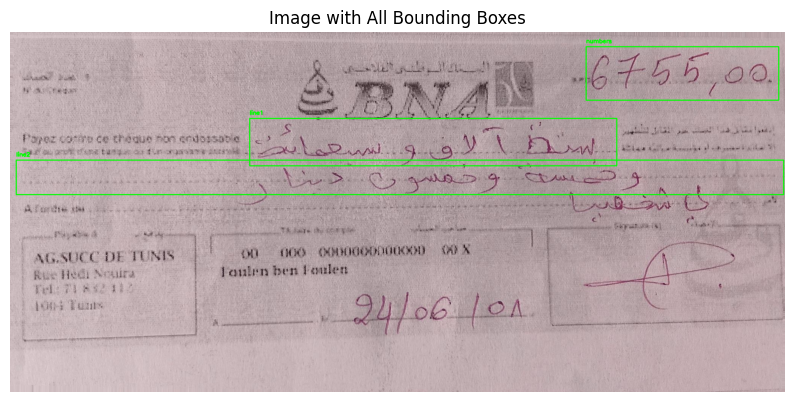

In [ ]:
import cv2
import numpy as np
import pandas
import matplotlib.pyplot as plt
from pathlib import Path

# Load the image
img_path = '/content/drive/MyDrive/yolo/cheque dz/valid/images/IMG_20240926_125456_jpg.rf.acee29fa39c88225a9d0867635ee24d7.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Assuming `model` is a detection model like YOLOv5, run inference
results = model(image)

# Copy the original image for drawing all boxes
img_with_boxes = np.copy(image)

# Loop over results and draw all boxes
for r in results:
    img_name = Path(r.path).stem

    for ci, c in enumerate(r.boxes):
        label = r.names[c.cls.tolist().pop()]

        # Get bounding box coordinates
        x1, y1, x2, y2 = c.xyxy.cpu().numpy().squeeze().astype(np.int32)

        # Draw rectangle on the copied image
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with all boxes
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Image with All Bounding Boxes")
plt.axis('off')
plt.show()

In [ ]:
!ls